# Loading dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn import __version__ as sklearnver
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import xgboost as xgb

print(f'sklearn version: {sklearnver}')
print(f'xgboost version: {xgb.__version__}')

sklearn version: 1.7.1
xgboost version: 3.0.5


# simulating Field keys and normalized values in which the input format will be converted into

In [2]:
target_column = 'dropoutFlag'

fieldKeys = [
  'age',
  'attendancePercentage',
  'lateSubmissionCount',
  'cgpa',
  'previousYearPerformance',
  'mathScore',
  'englishScore',
  'scienceScore',
  'projectScore',
  'totalMarks',
  'feesPaid',
  'libraryDues',
  'sportsScore',
  'behaviorScore',
  'scholarshipEligibility',
  'specialNeedsFlag'
]

model_columns = fieldKeys + [target_column]

model_columns

['age',
 'attendancePercentage',
 'lateSubmissionCount',
 'cgpa',
 'previousYearPerformance',
 'mathScore',
 'englishScore',
 'scienceScore',
 'projectScore',
 'totalMarks',
 'feesPaid',
 'libraryDues',
 'sportsScore',
 'behaviorScore',
 'scholarshipEligibility',
 'specialNeedsFlag',
 'dropoutFlag']

# Loading data

In [3]:
data = pd.read_csv('../data/final-data.csv').drop('notEnrolled', axis=1)
data.columns

Index(['studyMode', 'previousEducation', 'displacedStatus', 'specialNeeds',
       'gender', 'scholarShipStatus', 'ageAtEnrollment', 'international',
       'dropoutStatus', 'parentEducation', 'parentEmployentStatus', 'feesPaid',
       'totalCreditsEnrolled', 'totalCreditsApproved', 'cgpa'],
      dtype='object')

In [4]:
data.head()

,studyMode,previousEducation,displacedStatus,specialNeeds,gender,scholarShipStatus,ageAtEnrollment,international,dropoutStatus,parentEducation,parentEmployentStatus,feesPaid,totalCreditsEnrolled,totalCreditsApproved,cgpa
0,1,1,1,0,1,0,19,0,0,3,1,0,12.0,12.0,6.92
1,1,1,1,0,0,0,20,0,0,27,0,1,12.0,11.0,6.48
2,0,1,0,0,0,0,45,0,0,28,1,1,12.0,11.0,6.35
3,0,12,0,0,1,0,50,0,0,27,0,0,10.0,10.0,5.84
4,1,1,1,0,0,1,18,0,0,28,0,1,15.0,15.0,6.93


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   studyMode              35952 non-null  int64  
 1   previousEducation      35952 non-null  int64  
 2   displacedStatus        35952 non-null  int64  
 3   specialNeeds           35952 non-null  int64  
 4   gender                 35952 non-null  int64  
 5   scholarShipStatus      35952 non-null  int64  
 6   ageAtEnrollment        35952 non-null  int64  
 7   international          35952 non-null  int64  
 8   dropoutStatus          35952 non-null  int64  
 9   parentEducation        35952 non-null  int64  
 10  parentEmployentStatus  35952 non-null  int64  
 11  feesPaid               35952 non-null  int64  
 12  totalCreditsEnrolled   35952 non-null  float64
 13  totalCreditsApproved   35952 non-null  float64
 14  cgpa                   35952 non-null  float64
dtypes:

In [6]:
target = 'dropoutStatus'
continous_features = ['ageAtEnrollment', 'totalCreditsEnrolled', 'totalCreditsApproved', 'cgpa']
categorical_features = data.drop(continous_features + [target], axis=1).columns.to_list()

len(continous_features), len(categorical_features)

(4, 10)

# EDA

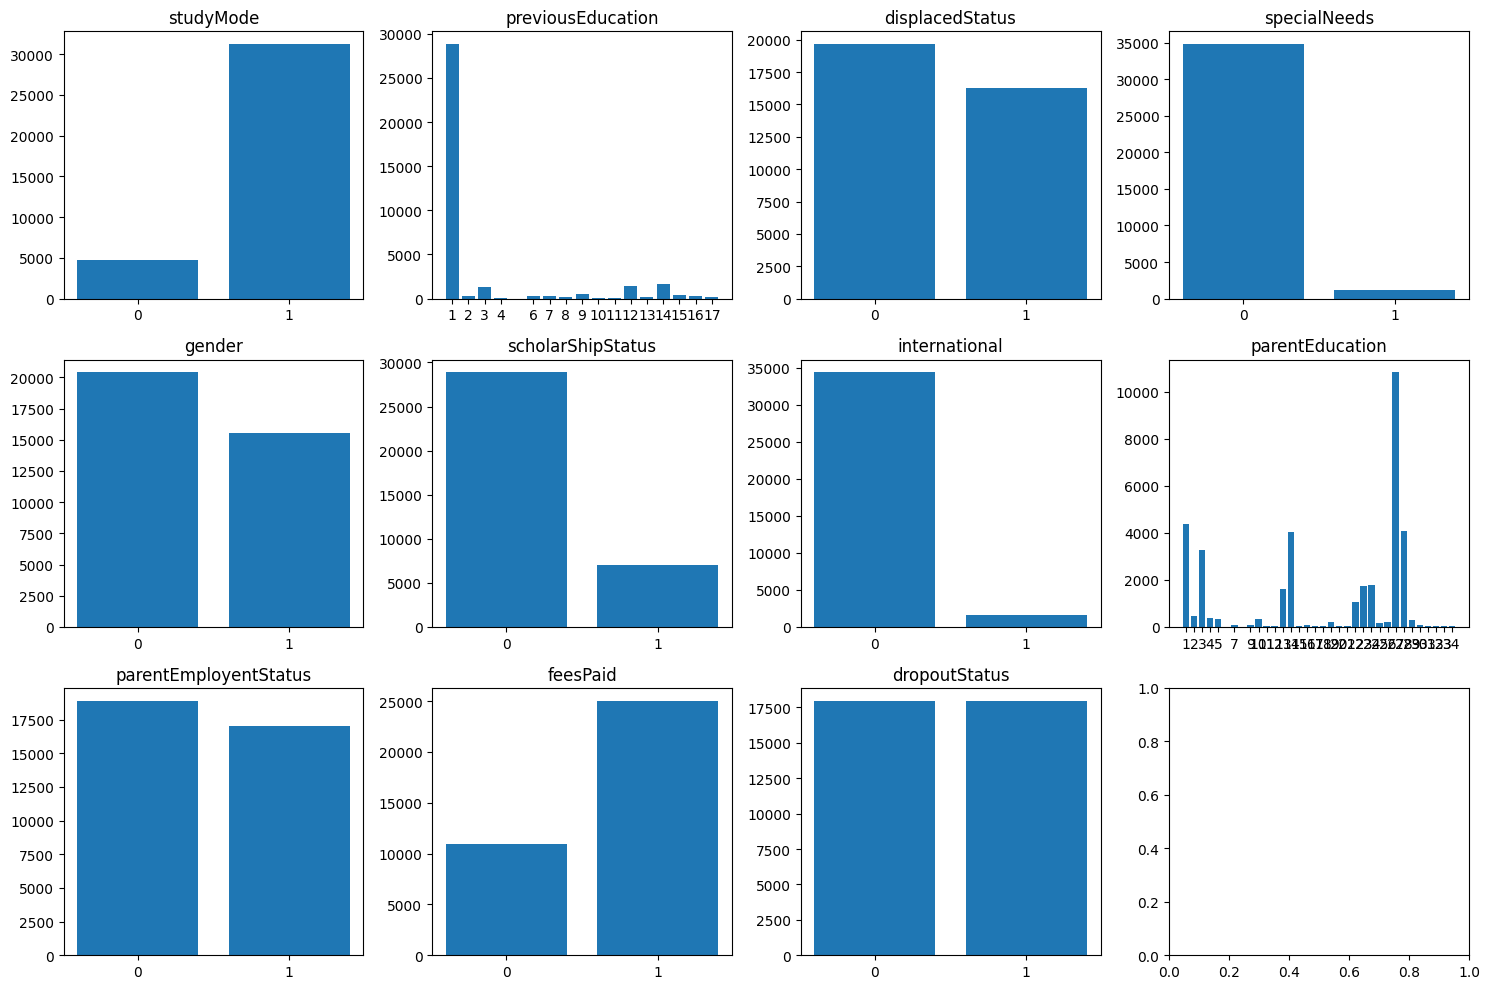

In [7]:
def show_dist(df, features):
  fig, axes = plt.subplots(3,4, figsize=(15,10))
  axes = axes.flatten()
  for ax, feature in zip(axes, features):
    value = df[feature].value_counts().reset_index()
    ax.bar(value[feature], value['count'])
    ax.set_title(feature)
    ax.set_xticks(value[feature].round())
  
  plt.tight_layout()
  plt.show()

show_dist(data, categorical_features + [target])

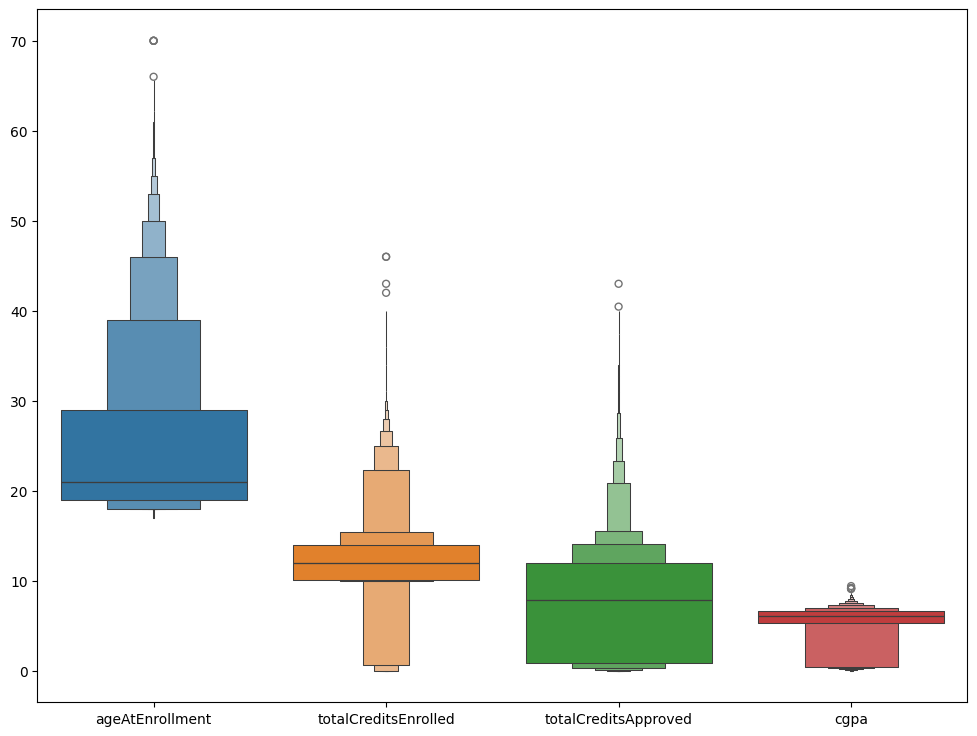

In [8]:
plt.figure(figsize=(12,9))
sns.boxenplot(data[continous_features])
plt.show()

# Preprocessing

In [9]:
minority = data[data['dropoutStatus'] == 1]
majority = data[data['dropoutStatus'] == 0]

upsampled_data = resample(
  minority,
  replace=True,
  n_samples=len(majority),
  random_state=42
)

balanced_data = pd.concat([majority, upsampled_data])
balanced_data.shape

(35952, 15)

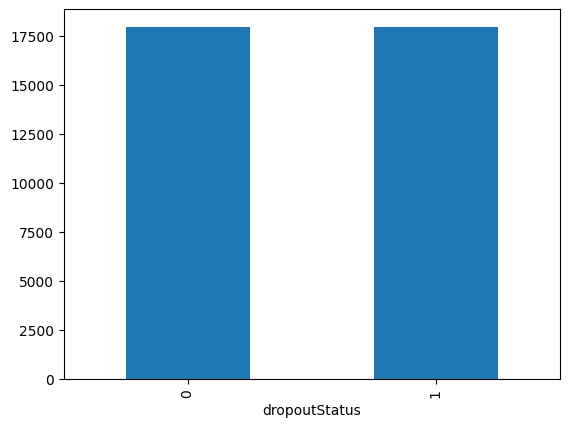

In [10]:
balanced_data['dropoutStatus'].value_counts().plot(kind='bar')
plt.show()

In [11]:
X, y = balanced_data.drop(target, axis=1), balanced_data[target]

sc = StandardScaler()
X_scaled = sc.fit_transform(X[continous_features])
X[sc.get_feature_names_out()] = X_scaled

X.shape, y.shape, X_scaled.shape

((35952, 14), (35952,), (35952, 4))

In [12]:
X.head()

,studyMode,previousEducation,displacedStatus,specialNeeds,gender,scholarShipStatus,ageAtEnrollment,international,parentEducation,parentEmployentStatus,feesPaid,totalCreditsEnrolled,totalCreditsApproved,cgpa
0,1,1,1,0,1,0,-0.685936,0,3,1,0,-0.039715,0.696499,0.749239
1,1,1,1,0,0,0,-0.581083,0,27,0,1,-0.039715,0.532343,0.581239
2,0,1,0,0,0,0,2.040250,0,28,1,1,-0.039715,0.532343,0.531603
3,0,12,0,0,1,0,2.564517,0,27,0,0,-0.433081,0.368187,0.336875
4,1,1,1,0,0,1,-0.790789,0,28,0,1,0.550334,1.188967,0.753057


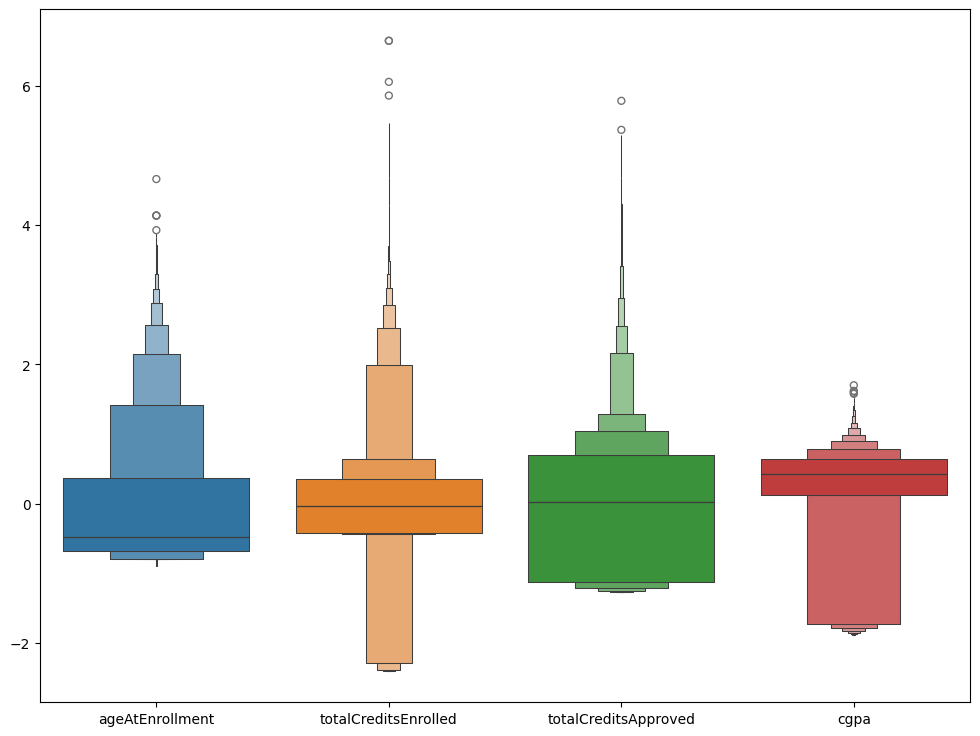

In [13]:
plt.figure(figsize=(12,9))
sns.boxenplot(X[continous_features])
plt.show()

# Model training

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape, X_test.shape

((28761, 14), (7191, 14))

In [16]:
X_train.columns

Index(['studyMode', 'previousEducation', 'displacedStatus', 'specialNeeds',
       'gender', 'scholarShipStatus', 'ageAtEnrollment', 'international',
       'parentEducation', 'parentEmployentStatus', 'feesPaid',
       'totalCreditsEnrolled', 'totalCreditsApproved', 'cgpa'],
      dtype='object')

In [15]:
train = xgb.DMatrix(data=X_train, label=y_train, nthread=-1)
test = xgb.DMatrix(data=X_test, label=y_test, nthread=-1)

In [53]:
model = xgb.XGBClassifier()

param_grid = {
  'n_estimators': [100,200,300],
  'max_depth': [6,10,15],
  'learning_rate': [0.001,0.01,0.1],
  'device': ['cuda'],
  'subsample': [1,0.5],
  'verbosity': [1]
}

grid = RandomizedSearchCV(model, param_grid, n_iter=30, scoring='f1', cv=5)

grid.fit(train.get_data(), train.get_label())

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'device': ['cuda'], 'learning_rate': [0.001, 0.01, ...], 'max_depth': [6, 10, ...], 'n_estimators': [100, 200, ...], ...}"
,n_iter,30
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [54]:
best_model = grid.best_estimator_

In [55]:
predictions = best_model.predict(X_test)

In [56]:
test_accuracy = accuracy_score(y_test, predictions)
print(f'Model accuracy on test data: {test_accuracy*100:0.2f}%')

Model accuracy on test data: 94.46%


In [57]:
class_report = classification_report(y_test, predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       615
           1       0.93      0.96      0.94       576

    accuracy                           0.94      1191
   macro avg       0.94      0.95      0.94      1191
weighted avg       0.95      0.94      0.94      1191



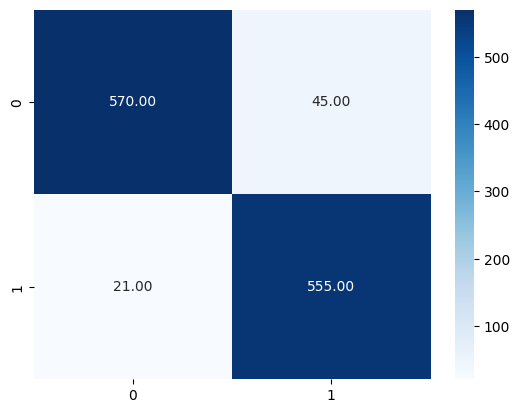

In [58]:
conf_mx = confusion_matrix(y_test, predictions)
sns.heatmap(conf_mx, annot=True, fmt='.2f', cmap='Blues')
plt.show()

In [59]:
pred_summary = pd.DataFrame({
  'real': y_test,
  'predictions': predictions
})

pred_summary

,real,predictions
5293,1,1
3808,1,1
1966,0,0
3668,1,1
1374,0,0
...,...,...
944,0,0
3964,1,1
2254,0,0
12,0,0


In [60]:
pred_summary[pred_summary['predictions'] != pred_summary['real']].sum().sum()

66

# Saving model for use

In [61]:
number_of_models = len(os.listdir('../models'))
joblib.dump(best_model, f'../models/model_{number_of_models+1}.pth')

['../models/model_3.pth']